# Model Explainability

In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_selector as selector
from sklearn.pipeline import Pipeline

import xgboost
import shap

import matplotlib.pyplot as plt
import seaborn as sns

/Users/brianroepke/miniforge3/envs/ML/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("bank.csv", delimiter=";")

In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


## Prep

In [4]:
# Separate the target variable from the rest of the data
X = df.iloc[:, :-1]
y = df.iloc[:,-1]

In [5]:
column_trans = ColumnTransformer(transformers=
        [('num', MinMaxScaler(), selector(dtype_exclude="object")),
        ('cat', OrdinalEncoder(), selector(dtype_include="object"))],
        remainder='drop')
    

In [6]:
le = LabelEncoder()
y = le.fit_transform(y)

In [7]:
# Split the data into 30% test and 70% training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## Coefficients in Logistic Regression

In [8]:
# Create a random forest classifier for feature importance
clf = LogisticRegression(random_state=42, 
                             max_iter=1000, 
                             class_weight='balanced')

pipeline = Pipeline([('prep',column_trans),
                        ('clf', clf)])

In [9]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x162ef1580>),
                                                 ('cat', OrdinalEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x162ef1cd0>)])),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

In [10]:
pipeline['clf'].coef_[0]

array([ 1.0249489 , -0.77473317, -0.05545831, 11.94810179, -3.46191268,
        1.6977722 ,  2.35175263,  0.0247226 ,  0.11248758,  0.21137858,
       -0.16868362, -0.77802822, -1.03491138, -0.64012296,  0.02555205,
        0.07620698])

In [11]:
print(f"The Y-Intercept is = {pipeline['clf'].intercept_[0]}")

The Y-Intercept is = -1.7984762353672181


In [12]:
feat_list = []
total_importance = 0
# Make a dataframe of Coeficients and Feature Names
for feature in zip(X, pipeline['clf'].coef_[0]):
    feat_list.append(feature)
    total_importance += feature[1]

# create DataFrame using data
df_imp = pd.DataFrame(feat_list, columns =['FEATURE', 'IMPORTANCE']).sort_values(by='IMPORTANCE', ascending=False)
df_imp.sort_values(by='IMPORTANCE', ascending=False)

,FEATURE,IMPORTANCE
3,education,11.948102
6,housing,2.351753
5,balance,1.697772
0,age,1.024949
9,day,0.211379
8,contact,0.112488
15,poutcome,0.076207
14,previous,0.025552
7,loan,0.024723
2,marital,-0.055458


## Feature Importances in Random Forest

In [13]:
# Create a random forest classifier for feature importance
clf = RandomForestClassifier(random_state=42, n_jobs=6, class_weight='balanced')

pipeline = Pipeline([('prep',column_trans),
                        ('clf', clf)])

In [14]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x162ef1580>),
                                                 ('cat', OrdinalEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x162ef1cd0>)])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced', n_jobs=6,
                                        random_state=42))])

In [15]:
pipeline['clf'].feature_importances_

array([0.08553007, 0.08938741, 0.07729421, 0.36724818, 0.03941122,
       0.0481177 , 0.02746841, 0.04751034, 0.02055133, 0.02369777,
       0.00093603, 0.02474706, 0.01358378, 0.04178285, 0.06769048,
       0.02504318])

In [25]:
feat_list = []

total_importance = 0
# Print the name and gini importance of each feature
for feature in zip(X, pipeline['clf'].feature_importances_):
    feat_list.append(feature)
    total_importance += feature[1]
        
# create DataFrame using data
df_imp = pd.DataFrame(feat_list, columns =['FEATURE', 'IMPORTANCE']).sort_values(by='IMPORTANCE', ascending=False)
df_imp['CUMSUM'] = df_imp['IMPORTANCE'].cumsum()
df_imp

,FEATURE,IMPORTANCE,CUMSUM
15,poutcome,0.289354,0.289354
5,balance,0.097970,0.387323
3,education,0.080529,0.467852
13,pdays,0.066708,0.534561
14,previous,0.055838,0.590399
12,campaign,0.050940,0.641339
6,housing,0.047924,0.689262
11,duration,0.047882,0.737144
2,marital,0.044196,0.781340
8,contact,0.040455,0.821795


## SHAP

In [18]:
clf = xgboost.XGBRegressor()

pipeline = Pipeline([('prep',column_trans),
                        ('clf', clf)])

In [19]:
pipeline.fit(X_train, y_train);

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


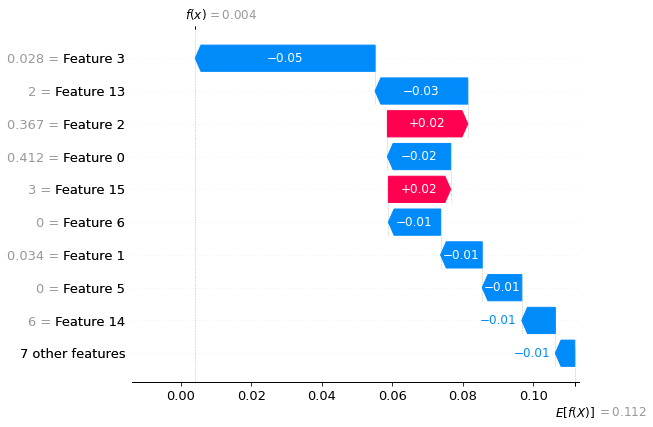

In [20]:
# train an XGBoost model
# X, y = shap.datasets.boston()
model = pipeline['clf']

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(pipeline['prep'].transform(X_train))

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[1])

In [21]:
for i in range (len(X.columns)):
    print(f"Feature {i}: {X.columns[i]}")

Feature 0: age
Feature 1: job
Feature 2: marital
Feature 3: education
Feature 4: default
Feature 5: balance
Feature 6: housing
Feature 7: loan
Feature 8: contact
Feature 9: day
Feature 10: month
Feature 11: duration
Feature 12: campaign
Feature 13: pdays
Feature 14: previous
Feature 15: poutcome


In [22]:
shap.initjs()
# visualize the first prediction's explanation
shap.plots.force(shap_values[0])

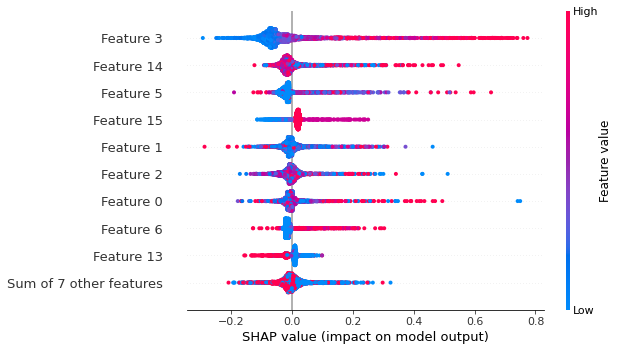

In [23]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

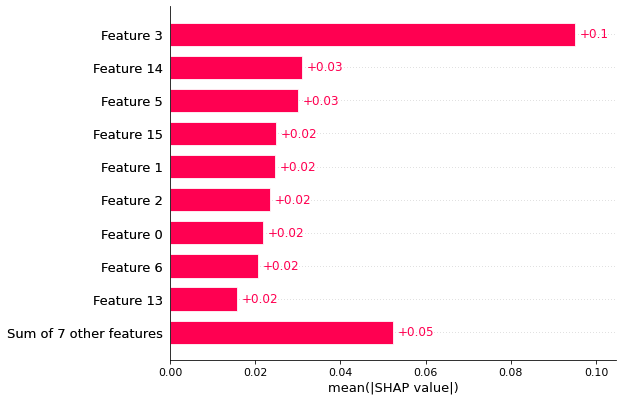

In [24]:
shap.plots.bar(shap_values)